### actual prediction sequence

In [ ]:
import numpy as np
start_time ="05-08-17-18-57-49" #"05-03-17-19-06-14"#"05-02-17-13-55-40"
exps=["logistic"]
#models = ["basic_rnn", "basic_lstm", "matrix_rnn", "tensor_rnn", "tensor_rnn_einsum"]
models=["basic_lstm","tensor_rnn_einsum"]

preds = []
for exp in exps:
    for model in models:
        data_path = "/tmp/tensorRNN/log/"+exp+"/"+start_time+"/"+model
        file_name = "predict.npy"
        print(data_path+"/"+file_name)
        try:
            pred = np.load(data_path+"/"+file_name) 
            preds.append(np.asarray(pred))
        except IOError:
            'no file'    
print(np.shape(pred))


In [ ]:
pred_lstm = preds[0]
pred_trnn = preds[1]
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 2)) #(9*16, width=3.5)

y_true, y_pred = pred_lstm
y_true = y_true[:100]
y_pred = y_pred[:100]
t = np.arange(0,len(y_true))
#plt.plot(t,y_pred,'r')

plt.subplot(1,4,1)
plt.plot(t,y_true,'b')


plt.subplot(1,4,2)
plt.plot(t,y_true,'r')


y_true, y_pred = pred_trnn
y_true = y_true[:100]
y_pred = y_pred[:100]
plt.subplot(1,4,3)
plt.plot(t,y_true,'b')

plt.subplot(1,4,4)
plt.plot(t,y_true,'r')

### version 2 logistic

In [ ]:
def gen_logistic_series(x0, num_steps, num_freq):
    alpha = 4.0
    x = np.ndarray((num_steps,1) )
    x[0]  = x0
    
    xx = np.ndarray((num_steps//num_freq,1))
    f = lambda  x ,t: alpha* x[t] * (1.0 - x[t]) 
    j = 0
    for t in range(num_steps-1):
        if t%num_freq ==0:
            xx[j]  = x[t]
            j += 1
        x[t+1] = f(x,t)
    logistic_series = xx
    return logistic_series


def gen_logistic_dataset(file_name = "logistic.pkl"):
    """generate set of chaotic time series with randomly selected initial"""
    num_samples = int(1e2)
    num_freq = int(1)
    num_steps = int(1e2)*num_freq
    
    init_range = np.random.uniform(0.0,1.0,(num_samples,1))
   
    logistic_series_mat = np.ndarray((num_samples, num_steps//num_freq, 1))

    for i in range(num_samples):
        x0 = init_range[i,:]
        series = gen_logistic_series(x0, num_steps, num_freq )
        logistic_series_mat[i,:,:] = series
    return logistic_series_mat

data = gen_logistic_dataset()
print("data_shape:"), np.shape(data)
#pickle.dump(data,open("/home/roseyu/data/tensorRNN/logistic.pkl","wb"))

    #    pickle.dump(x_mat,open(file_name,"wb"))

In [ ]:
%matplotlib inline
import matplotlib as mpl

params = {
   'axes.labelsize': 12,
   'text.fontsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [2, 2]
   }
mpl.rcParams.update(params)


fig = plt.figure(figsize=(5.25,3.5))
ax = fig.gca()

N = 10
len_ts = 20
idxs = np.random.choice(range(np.shape(data)[0]), N)


for i in idxs:
    ax.plot(data[i,:len_ts],'b')
    ax.scatter(np.arange(len_ts), data[i,:len_ts], c='r',s = 50, alpha=0.5)

ax.set_xlim((0,N+1))
ax.set_ylim((-0.1,1.1))

ax.set_xlabel("Time")
ax.set_ylabel("Value")
fig.savefig('/home/roseyu/logistic.pdf', transparent=True)

### version 2 lorenz 

In [ ]:
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

params = {
   'axes.labelsize': 12,
   'text.fontsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
mpl.rcParams.update(params)

print("data_shape:"), np.shape(data_mat)
N = 10
# xs = data_mat[0:N,:,0]
# ys = data_mat[0:N,:,1]
# zs = data_mat[0:N,:,2]
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

def mm(x):
    return np.min(x)-10, np.max(x)+10

idxs = np.random.choice(range(data_mat.shape[0]), N)
print(idxs)
T=50
for i in idxs:
    print("xyz0:",data_mat[i,0])
    ax.plot(data_mat[i,:T,0], data_mat[i,:T,1], data_mat[i,:T,2], 'b')
    ax.scatter(data_mat[i,:T,0], data_mat[i,:T,1], data_mat[i,:T,2], c='r', s=50)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(*mm(xs))
ax.set_ylim(*mm(ys))
ax.set_zlim(*mm(zs))
fig.savefig('/home/roseyu/lorenz.pdf', transparent=True)

### test error comparison  

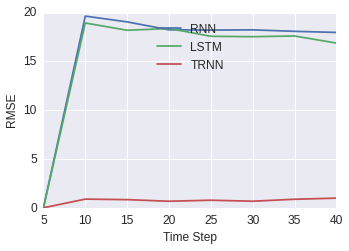

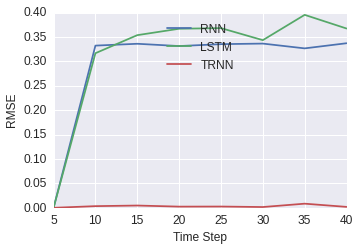

In [89]:
lorenz_mat = np.load("/tmp/tensorRNN/log/lorenz/05-09-17-19-31-50/test_err.npy")
fig = plt.figure(figsize=(5.25,3.5))
ax = fig.gca()
ax.plot(lorenz_mat)
ax.set_xlabel("Time Step")
ax.set_ylabel("RMSE")
plt.setp(plt.gca(), 'xticklabels', [str(x) for x in np.arange(5,45,5)])
plt.legend(('RNN', 'LSTM', 'TRNN'),
           'upper center', shadow=True, fancybox=True)

lorenz_mat = np.load("/tmp/tensorRNN/log/logistic/05-09-17-19-31-50/test_err.npy")
fig = plt.figure(figsize=(5.25,3.5))
ax = fig.gca()
ax.plot(lorenz_mat)
ax.set_xlabel("Time Step")
ax.set_ylabel("RMSE")
plt.setp(plt.gca(), 'xticklabels', [str(x) for x in np.arange(5,45,5)])
plt.legend(('RNN', 'LSTM', 'TRNN'),
           'upper center', shadow=True, fancybox=True)

### projection of the weight vector

In [ ]:
import tensorflow as tf
from tensorflow.python.framework import ops
sess = tf.Session()
time_stamp ="05-08-17-19-02-03"
file_path = "/tmp/tensorRNN/log/logistic/"+time_stamp+"/tensor_rnn_einsum/"

meta_file = "model.ckpt-307800.meta"
model_file = "model.ckpt-307800"
new_saver = tf.train.import_meta_graph(file_path+meta_file)
#print( tf.train.latest_checkpoint('./'))
what=new_saver.restore(sess, file_path+model_file)
#print(what)
all_vars = tf.get_collection(ops.GraphKeys.GLOBAL_VARIABLES)
print(all_vars)

w_h1_name = "Model/tensor_rnn/multi_rnn_cell/cell_0/tensor_rnn_cell/tensor_network_tt/weights_h:0"
w_h2_name = "Model/tensor_rnn/multi_rnn_cell/cell_1/tensor_rnn_cell/tensor_network_tt/weights_h:0"
for v in all_vars:
    if v.name==w_h1_name:
        w_h1 = sess.run(v)
    if v.name==w_h2_name:
        w_h2 = sess.run(v)
    #     print(v_)

In [ ]:
# visualization the transition weights (auto-correlation)
import numpy as np
state_size = output_size = 64
num_lags = 3
num_orders = 2
rank_vals = [1]

total_state_size = (state_size * num_lags + 1 )
print("total_state_size:", total_state_size)
mat_dims = np.ones((num_orders,)) * total_state_size
mat_ranks = np.concatenate(([1], rank_vals, [output_size]))
mat_dims = np.ones((num_orders,)) * total_state_size

mat_ps = np.cumsum(np.concatenate(([0], mat_ranks[:-1] * mat_dims * mat_ranks[1:])),dtype=np.int32)
mat_size = mat_ps[-1]
Ws = []

for i in range(0, num_orders ):
    mat_core = w_h1[mat_ps[i]: mat_ps[i + 1]]
    mat_core = np.reshape(mat_core, [mat_ranks[i], total_state_size, mat_ranks[i + 1]])
    Ws.append(mat_core)
print(len(Ws)) # a series of tensor-train components 

In [ ]:
%matplotlib inline 
print Ws[0].shape, Ws[1].shape

W0 = Ws[1]
W0_t = W0[:,0:192,:]
b0 = W0[:,-1,:]
W0_t = np.reshape(W0_t,[num_lags,state_size, np.shape(W0)[-1]])
for l in range(num_lags):
    plt.imshow(W0_t[l,:,:], cmap='hot', interpolation='nearest')
    plt.show()


In [ ]:
W0 = Ws[0]
W0 =np.squeeze(W0)
plt.plot(W0)
plt.axvline(x=64, c='r')
plt.axvline(x=128,c='r')

In [ ]:
for v in all_vars:
    print v
print w_h1.shape
print w_h2.shape